In [1]:
import networkx as nx

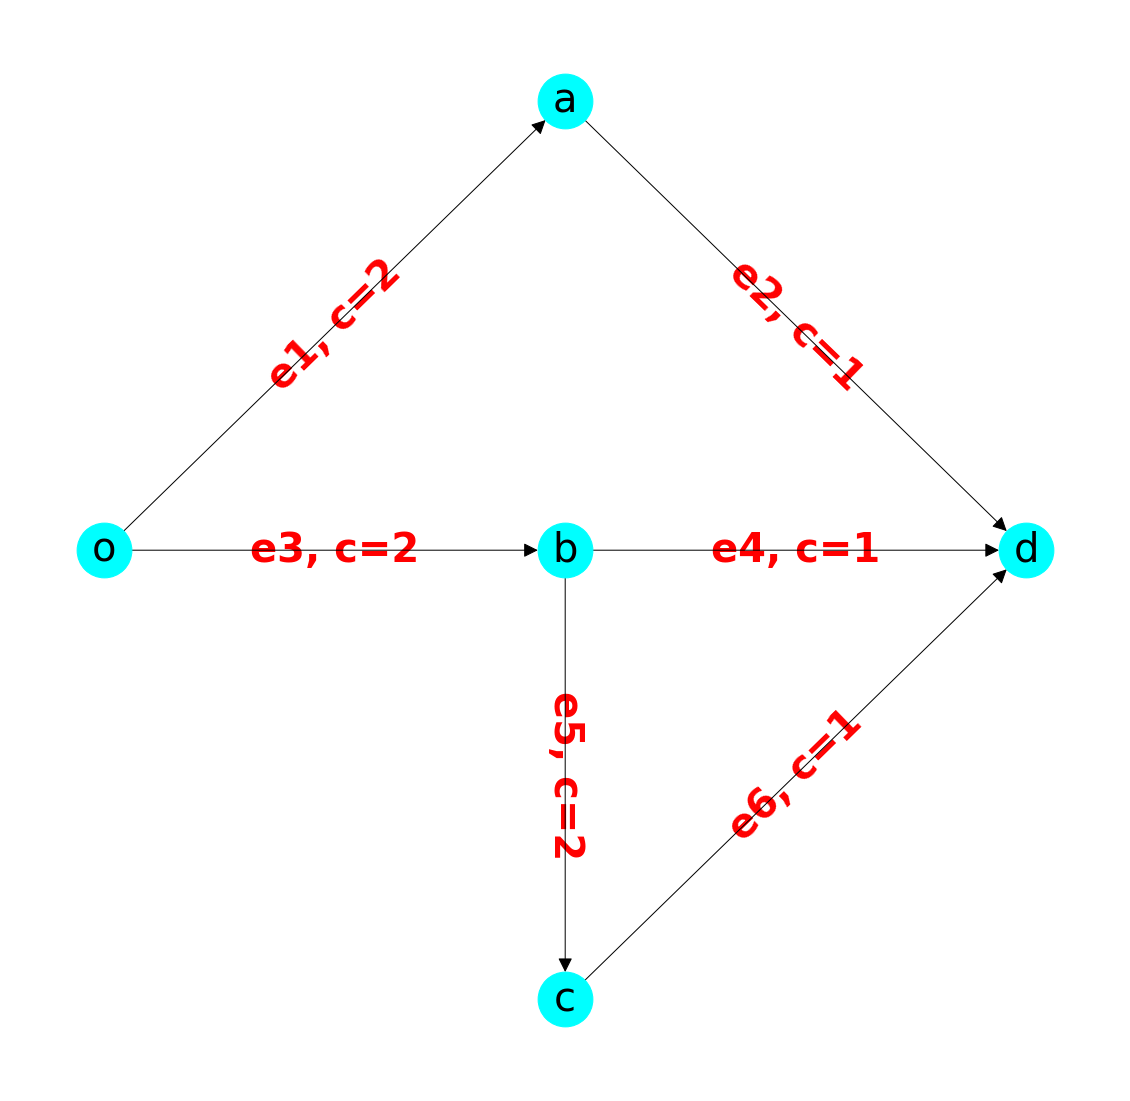

In [2]:

import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('a','d'),('b','c'),('b','d'),('c','d')])

pos = {'b':[1,0], 'a':[1,1], 'c':[1,-1], 'd':[2,0], 'o':[0,0]}
plt.figure(figsize=(20, 20))
nx.draw_networkx_edge_labels(G,pos,edge_labels={('o','a'):'e1, c=2',('o','b'):'e3, c=2',('a','d'):'e2, c=1',('b','c'):'e5, c=2',('b','d'):'e4, c=1',('c','d'):'e6, c=1'},font_color='red', font_size=40, font_weight='bold')
nx.draw(G, pos, node_color='#00ffff', arrowsize=30, node_size=3000, font_size=40, with_labels=True)

In [3]:
G['o']['a']['capacity'] = 2
G['o']['b']['capacity'] = 2
G['a']['d']['capacity'] = 1
G['b']['c']['capacity'] = 2
G['b']['d']['capacity'] = 1
G['c']['d']['capacity'] = 1

In [4]:
origin = 'o'
destination = 'd'

In [5]:
maximal_throughput, flows = nx.algorithms.flow.maximum_flow(G,origin,destination)
print("max throughput: \n", maximal_throughput)
print("flows: \n", flows)

max throughput: 
 3
flows: 
 {'o': {'a': 1, 'b': 2}, 'a': {'d': 1}, 'b': {'c': 1, 'd': 1}, 'd': {}, 'c': {'d': 1}}


In [6]:
minimal_cut_capacity, min_cut_node_partition = nx.algorithms.flow.minimum_cut(G,origin,destination)
print("minimal cut capacity: \n", minimal_cut_capacity)
print("minimal cut, node partition: \n", min_cut_node_partition)

minimal cut capacity: 
 3
minimal cut, node partition: 
 ({'b', 'a', 'o', 'c'}, {'d'})


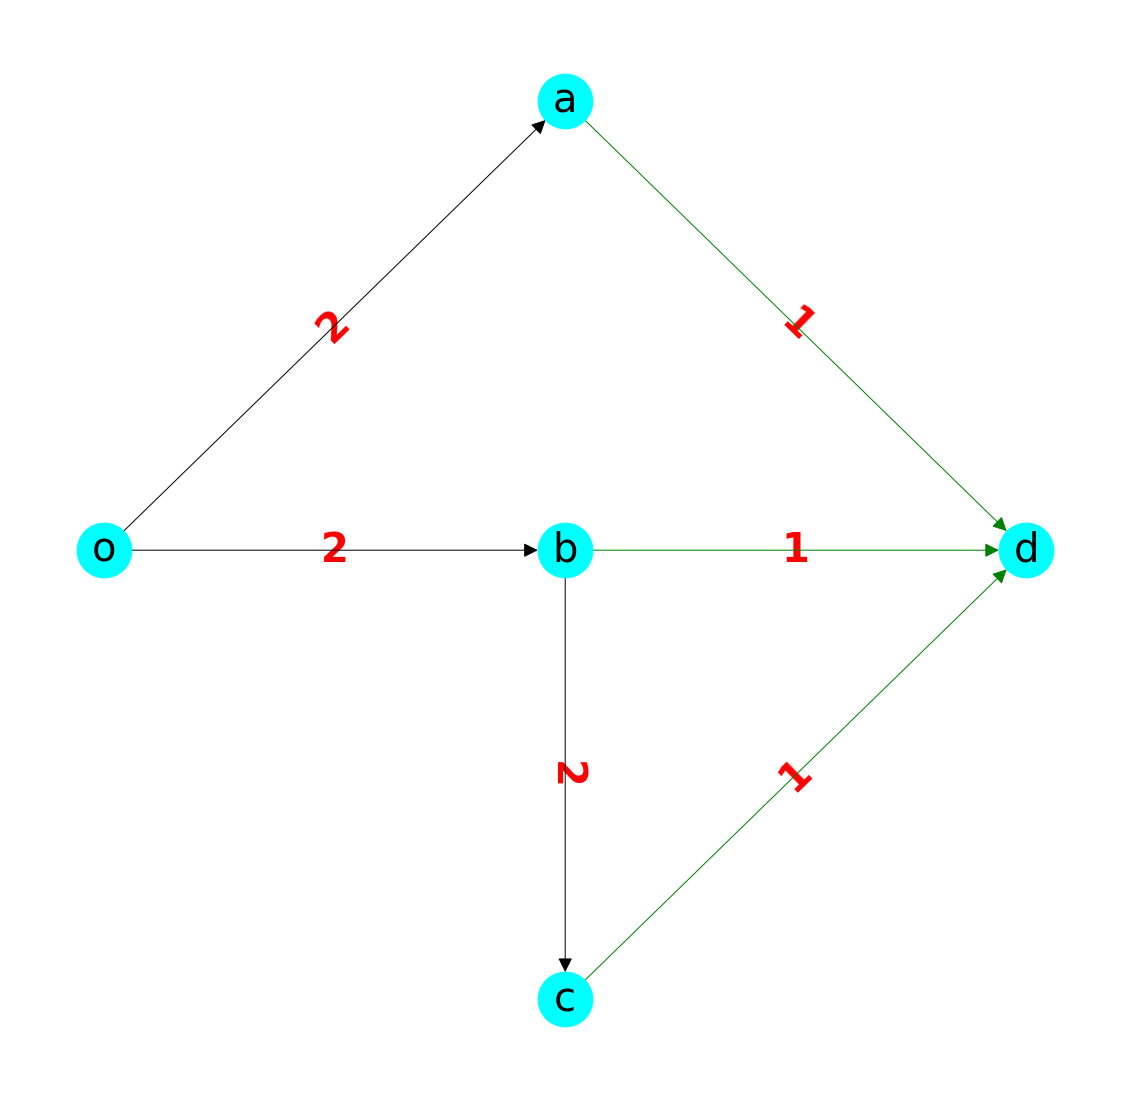

In [7]:
for edge in G.edges:
    if (edge[0] in min_cut_node_partition[0] and edge[1] in min_cut_node_partition[1]) or (edge[0] in min_cut_node_partition[1] and edge[1] in min_cut_node_partition[0]):
        G[edge[0]][edge[1]]['color'] = 'green'
    else:
        G[edge[0]][edge[1]]['color'] = 'black'

colors = [G[u][v]['color'] for u,v in G.edges()]
plt.figure(figsize=(20, 20))
nx.draw_networkx_edge_labels(G,pos,edge_labels={('o','a'):'2',('o','b'):'2',('a','d'):'1',('b','c'):'2',('b','d'):'1',('c','d'):'1'},font_color='red', font_size=40, font_weight='bold')
nx.draw(G, pos, node_color='#00ffff', arrowsize=30, node_size=3000, font_size=40, with_labels=True,  edge_color = colors)

Point a.

In [8]:
capacity_removed = 0
for edge in G.edges:
    if (edge[0] in min_cut_node_partition[0] and edge[1] in min_cut_node_partition[1]) or (edge[0] in min_cut_node_partition[1] and edge[1] in min_cut_node_partition[0]):
        G[edge[0]][edge[1]]['capacity'] -= 1
        capacity_removed += 1
    

In [9]:
capacity_removed

3

In [10]:
maximal_throughput, flows = nx.algorithms.flow.maximum_flow(G,origin,destination)
print("max throughput: \n", maximal_throughput)
print("flows: \n", flows)

max throughput: 
 0
flows: 
 {'o': {'a': 0, 'b': 0}, 'a': {'d': 0}, 'b': {'c': 0, 'd': 0}, 'd': {}, 'c': {'d': 0}}


In [11]:
minimal_cut_capacity, min_cut_node_partition = nx.algorithms.flow.minimum_cut(G,origin,destination)
print("minimal cut capacity: \n", minimal_cut_capacity)
print("minimal cut, node partition: \n", min_cut_node_partition)

minimal cut capacity: 
 0
minimal cut, node partition: 
 ({'b', 'a', 'o', 'c'}, {'d'})


Point b.

In [12]:
#restoring original capacities.

In [13]:
G['o']['a']['capacity'] = 2
G['o']['b']['capacity'] = 2
G['a']['d']['capacity'] = 1
G['b']['c']['capacity'] = 2
G['b']['d']['capacity'] = 1
G['c']['d']['capacity'] = 1

In [14]:
# recursive algorithm to generate all k-partitions of a given set.
def SP_rec(n, k, m, pos, sol, val, out):
    if (pos >= n):
        if (m == k):
            curr = []
            for i in range(0, m):
                sub = []
                for j in range(0, n):
                    if (sol[j]==i):
                        sub.append(val[j])
                curr.append(sub)
            out.append(curr)
        return

    for i in range(0, m):
        sol[pos] = i;
        SP_rec(n, k, m, pos+1, sol, val, out);

    sol[pos] = m;
    SP_rec(n, k, m+1, pos+1, sol, val, out);

In [15]:
# generate all partitions of a set 'val' such that each partition has k subsets.
def set_partitions(val, k):
    n = len(val)
    out = []
    sol = [0]*n
    SP_rec(n, k, 0, 0, sol, val, out);
    return out;

In [16]:
def od_cuts(G):
    partitions = []
    for part in set_partitions(list(G.nodes),2):
        if (origin in part[0] and destination in part[1]) or (origin in part[1] and destination in part[0]): # if o in the first subset and d in the second or viceversa
            if origin in part[1]: # if o in the second subset, swap first and second subset (conventionally, o is always in the first subset)
                tmp = part[1]
                part[1] = part[0]
                part[0] = tmp
            cut_cap = 0
            cut_edges = []
            for edge in G.edges:
                if (edge[0] in part[0]) and (edge[1] in part[1]): # if edge belongs to the cut 
                    cut_cap += G[edge[0]][edge[1]]['capacity'] # update cut capacity
                    cut_edges.append(edge) # add edge 
            partitions.append((part, cut_cap, cut_edges)) # add a cut as a triple cut = (nodes_subsetes, capacity, edges_of_the_cut)
    return partitions

In [17]:
def extract_edges_not_in_min_cuts(G, min_cap):
    out = []
    edges_min_cuts = []
    cuts = od_cuts(G) # get all od cuts
    cuts.sort(key = lambda i:i[1]) # sort cuts by their capacity
    min_cut = cuts[0][1] # get the min capacity
    if min_cap!=min_cut: # if the min capacity is not the min capacity requested, return an empy list 
        return out
    for i in(cuts):
        if i[1] == min_cut: # extract edges of a minimum cut
            edges_min_cuts.extend(i[2])
        else:
            break
    for edge in G.edges:
        if edge not in (edges_min_cuts): # extract edges not belonging to a minimum cut
            out.append(edge)
    return out

In [18]:
def rec_remove_capacity(G, cap, cap_rem, max_cap_rem):
    for edge in extract_edges_not_in_min_cuts(G, cap): # for each edge in the set of edges belonging to a minimum cut
        node1 = edge[0]
        node2 = edge[1]
        G[node1][node2]['capacity'] -= 1 # remove a unit of capacity
        cap_rem += 1 # update total capacity removed
        if cap_rem > max_cap_rem: # update the max capacity removed if necessary
            max_cap_rem = cap_rem 
        max_cap_rem = rec_remove_capacity(G, cap, cap_rem, max_cap_rem) # recursive descent
        G[node1][node2]['capacity'] += 1 # backtrack: unit of capacity reassigned
        cap_rem -= 1 # backtrack: total capacity removed decreased
    return max_cap_rem # return max capacity removed

In [19]:
cuts = od_cuts(G) # get od-cuts
min_cut_cap = min([l[1] for l in cuts]) #compute the minimum od cut

In [20]:
print("Maximum aggregate capacity that can be removed:", rec_remove_capacity(G, min_cut_cap, 0, 0))

Maximum aggregate capacity that can be removed: 2


Point b. -- version with output

In [21]:
#restoring original capacities.

In [22]:
G['o']['a']['capacity'] = 2
G['o']['b']['capacity'] = 2
G['a']['d']['capacity'] = 1
G['b']['c']['capacity'] = 2
G['b']['d']['capacity'] = 1
G['c']['d']['capacity'] = 1

In [23]:
cuts = od_cuts(G)
min_cut_cap = min([l[1] for l in cuts])

In [24]:
def rec_remove_capacity_print(G, cap, cap_rem, max_cap_rem):
    cuts = od_cuts(G)
    spaces = ""
    for i in range(0, cap_rem):
        spaces += "       "
    print(spaces, "o-d cuts, with their capacity")
    cuts.sort(key = lambda i:i[1])
    for i in cuts:
        print(spaces, "cut: ", i[0], "; cap: ", i[1])
    print()
    print(spaces, "edges not belonging to an o-d cut with minumum capacity")
    extrac_edges = extract_edges_not_in_min_cuts(G, cap)
    if len(extrac_edges)==0:
        print(spaces, "-- no edges.")
    for i in extrac_edges:
        print(spaces, i)
    for edge in extrac_edges:
        node1 = edge[0]
        node2 = edge[1]
        G[node1][node2]['capacity'] -= 1
        print(spaces, "Capacity of edge", edge, "decreased by 1.\n\n")
        cap_rem += 1
        if cap_rem > max_cap_rem:
            max_cap_rem = cap_rem
        max_cap_rem = rec_remove_capacity_print(G, cap, cap_rem, max_cap_rem)
        G[node1][node2]['capacity'] += 1
        cap_rem -= 1
    return max_cap_rem

In [25]:
print("\n\nMaximum aggregate capacity that can be removed:", rec_remove_capacity_print(G, min_cut_cap, 0, 0))

 o-d cuts, with their capacity
 cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  3
 cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  3
 cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  4
 cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  4
 cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  4
 cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4
 cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5
 cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  5

 edges not belonging to an o-d cut with minumum capacity
 ('o', 'a')
 ('b', 'c')
 Capacity of edge ('o', 'a') decreased by 1.


        o-d cuts, with their capacity
        cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  3
        cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  3
        cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  3
        cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  3
        cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  4
        cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  4
        cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  4
        cut:  [['o', 'c'], ['a', 'b', 'd']] ; ca

Point c.

In [26]:
#restoring original capacities.

In [27]:
G['o']['a']['capacity'] = 2
G['o']['b']['capacity'] = 2
G['a']['d']['capacity'] = 1
G['b']['c']['capacity'] = 2
G['b']['d']['capacity'] = 1
G['c']['d']['capacity'] = 1

In [28]:
# recursive algorithm to generate all subsets belonging to the powerset of a given set.
def powerset_rec(pos, val, sol, k, start, out):
    if (start >= k):
        curr = []
        for i in range(0, pos):
            curr.append(sol[i])
        out.append(curr)
        return
    for i in range(start, k):
        sol[pos] = val[i]
        powerset_rec(pos+1, val, sol, k, i+1, out)
    powerset_rec(pos, val, sol, k, k, out)
    return

In [29]:
# generate all partitions of a set 'val' such that each partition has k subset.
def set_powerset(val):
    n = len(val)
    out = []
    sol = [0]*n
    powerset_rec(0, val, sol, n, 0, out)
    return out;

In [30]:
def extract_edges_in_min_cuts(G):
    out = []
    edges_min_cuts = []
    cuts = od_cuts(G) # get od cuts
    cuts.sort(key = lambda i:i[1]) # sort cuts by capacity 
    min_cut = cuts[0][1] # get min capacity
    for i in(cuts): 
        if i[1] == min_cut: # if the cut capacity is min, extract its edges 
            edges_min_cuts.extend(i[2])
        else:
            break
    return edges_min_cuts

In [31]:
extra_capacity = 0

In [32]:
print(extra_capacity, "extra unit of capacity. Max throughput equals the capacity of the min cut.")

0 extra unit of capacity. Max throughput equals the capacity of the min cut.


In [33]:
cuts = od_cuts(G) # get all od cuts
cuts.sort(key = lambda i:i[1]) # sort cuts by their capacity
min_cat_cap = cuts[0][1] # get the min capacity
    
print("o-d cuts, with their capacity")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1])
print()

o-d cuts, with their capacity
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  3
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  3
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  4
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  4
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  4
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  5



In [34]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 3


In [35]:
throughput_per_cap = {}
throughput_per_cap[extra_capacity] = min_cat_cap

In [36]:
extra_capacity += 1

In [37]:
print("1 extra unit of capacity. Total extra capacity added:", extra_capacity)

1 extra unit of capacity. Total extra capacity added: 1


In [38]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1], "; edges of the cut: ", i[2])
print()

o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  3 ; edges of the cut:  [('a', 'd'), ('b', 'd'), ('c', 'd')]
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  3 ; edges of the cut:  [('o', 'b'), ('a', 'd')]
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  4 ; edges of the cut:  [('a', 'd'), ('b', 'c'), ('b', 'd')]
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  4 ; edges of the cut:  [('o', 'b'), ('a', 'd'), ('c', 'd')]
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  4 ; edges of the cut:  [('o', 'a'), ('b', 'd'), ('c', 'd')]
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4 ; edges of the cut:  [('o', 'a'), ('o', 'b')]
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('b', 'c'), ('b', 'd')]
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('o', 'b'), ('c', 'd')]



In [39]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 3


In [40]:
print("edges belonging to an o-d cut with minumum capacity")
extrac_edges = extract_edges_in_min_cuts(G) # get edges belonging to a min cut
for i in extrac_edges:
    print(i)

edges belonging to an o-d cut with minumum capacity
('a', 'd')
('b', 'd')
('c', 'd')
('o', 'b')
('a', 'd')


In [41]:
powerset = set_powerset(list(set(extrac_edges))) # get the powerset of the set of edges belonging to a min cut
powerset.sort(key = lambda i:len(i)) # sort by cardinality of the subset
current_cap = min_cat_cap # current min cut capacity 
found = False
curr_len = 0 # current min cardinality of the (sub)sets 
for edge_set in powerset[1:]: # do not consider empty set, for each set in the powerset 
    if (found and len(edge_set)>curr_len): # if an accettable set with a lower cardinality has already been found, break (interested in the sets with lower cardinality)
        break
    curr_len = len(edge_set) # update current min cardinality of the sets 
    print("capacity of:")
    for i in edge_set:
        print(i, "edge is increased by 1.")
        G[i[0]][i[1]]['capacity'] += 1 # increase capacity of each edge in the set
    cuts = od_cuts(G) # get the new od cut in the graph G 
    cuts.sort(key = lambda i:i[1]) # sort cuts by their capacity
    min_cat_cap = cuts[0][1] # get the min capacity
    if min_cat_cap > current_cap: # if the min cut capacity is increased, an accettable set is found 
        found = True
    print("o-d cuts, with their capacity after extra capacity assigned.") # print od cuts after extra cap assigned 
    for i in cuts:
        print("cut: ", i[0], "; cap: ", i[1])
    print("\n\n\n")
    for i in edge_set:
        G[i[0]][i[1]]['capacity'] -= 1 # restore initial capacities
        

capacity of:
('b', 'd') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  3
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  4
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  4
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  5
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  5
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  6




capacity of:
('c', 'd') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  3
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  4
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  4
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  5
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  6




capacity of:
('o', 'b') edge is increa

In [42]:
print("capacity of ('a', 'd') edge is increased by 1 since it is the subset of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased. (('a', 'd') contained in both sets of edges of min o-d cuts.)")
G['a']['d']['capacity'] += 1

capacity of ('a', 'd') edge is increased by 1 since it is the subset of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased. (('a', 'd') contained in both sets of edges of min o-d cuts.)


In [43]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity after extra capacity assigned to ('a', 'd') edge")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1])
print()

o-d cuts, with their capacity after extra capacity assigned to ('a', 'd') edge
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  4
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  4
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  4
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  5
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  5
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  5



In [44]:
print("Max throughput equals the capacity of the min cut.")

Max throughput equals the capacity of the min cut.


In [45]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 4


In [46]:
throughput_per_cap[extra_capacity] = min_cat_cap

In [47]:
extra_capacity += 1

In [48]:
print("1 extra unit of capacity. Total extra capacity added:", extra_capacity)

1 extra unit of capacity. Total extra capacity added: 2


In [49]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1], "; edges of the cut: ", i[2])
print()

o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  4 ; edges of the cut:  [('a', 'd'), ('b', 'd'), ('c', 'd')]
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  4 ; edges of the cut:  [('o', 'b'), ('a', 'd')]
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  4 ; edges of the cut:  [('o', 'a'), ('b', 'd'), ('c', 'd')]
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4 ; edges of the cut:  [('o', 'a'), ('o', 'b')]
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  5 ; edges of the cut:  [('a', 'd'), ('b', 'c'), ('b', 'd')]
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  5 ; edges of the cut:  [('o', 'b'), ('a', 'd'), ('c', 'd')]
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('b', 'c'), ('b', 'd')]
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('o', 'b'), ('c', 'd')]



In [50]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 4


In [51]:
print("edges belonging to an o-d cut with minumum capacity")
extrac_edges = extract_edges_in_min_cuts(G)
for i in extrac_edges:
    print(i)

edges belonging to an o-d cut with minumum capacity
('a', 'd')
('b', 'd')
('c', 'd')
('o', 'b')
('a', 'd')
('o', 'a')
('b', 'd')
('c', 'd')
('o', 'a')
('o', 'b')


In [52]:
powerset = set_powerset(list(set(extrac_edges)))
powerset.sort(key = lambda i:len(i))
current_cap = min_cat_cap
found = False
curr_len = 0
for edge_set in powerset[1:]:
    if (found and len(edge_set)>curr_len):
        break
    curr_len = len(edge_set)
    print("capacity of:")
    for i in edge_set:
        print(i, "edge is increased by 1.")
        G[i[0]][i[1]]['capacity'] += 1
    cuts = od_cuts(G)
    cuts.sort(key = lambda i:i[1])
    min_cat_cap = cuts[0][1]
    if min_cat_cap > current_cap:
        found = True
    print("o-d cuts, with their capacity after extra capacity assigned.")
    for i in cuts:
        print("cut: ", i[0], "; cap: ", i[1])
    print("\n\n\n")
    for i in edge_set:
        G[i[0]][i[1]]['capacity'] -= 1


capacity of:
('o', 'a') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  4
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  4
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  5
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  5
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  6
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  6




capacity of:
('a', 'd') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  4
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  4
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  5
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  6
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  6




capacity of:
('b', 'd') edge is increa

In [53]:
print("3 possibilities available: 3 different subsets of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased.")

3 possibilities available: 3 different subsets of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased.


In [54]:
print("1st possibility. Capacity of ('o', 'a') and ('a', 'd') edges is increased by 1.")
G['o']['a']['capacity'] += 1
G['a']['d']['capacity'] += 1

1st possibility. Capacity of ('o', 'a') and ('a', 'd') edges is increased by 1.


In [55]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity after extra capacity assigned to ('o', 'a') and ('a', 'd') edges")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1])
print()

o-d cuts, with their capacity after extra capacity assigned to ('o', 'a') and ('a', 'd') edges
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  6
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  6
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  6
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  6



In [56]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 5


In [57]:
G['o']['a']['capacity'] -= 1
G['a']['d']['capacity'] -= 1
print("2nd possibility. Capacity of ('b', 'd') and ('o', 'b') edges is increased by 1.")
G['b']['d']['capacity'] += 1
G['o']['b']['capacity'] += 1

2nd possibility. Capacity of ('b', 'd') and ('o', 'b') edges is increased by 1.


In [58]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity after extra capacity assigned to ('b', 'd') and ('o', 'b') edges")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1])
print()

o-d cuts, with their capacity after extra capacity assigned to ('b', 'd') and ('o', 'b') edges
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  6
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  6
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  6
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  6



In [59]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 5


In [60]:
G['b']['d']['capacity'] -= 1
G['o']['b']['capacity'] -= 1
print("1st and 2nd possibilities are equivalent.")

1st and 2nd possibilities are equivalent.


In [61]:
print("3rd possibility. Capacity of ('c', 'd') and ('o', 'b') edges is increased by 1.")
G['c']['d']['capacity'] += 1
G['o']['b']['capacity'] += 1

3rd possibility. Capacity of ('c', 'd') and ('o', 'b') edges is increased by 1.


In [62]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity after extra capacity assigned to ('c', 'd') and ('o', 'b') edges")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1])
print()

o-d cuts, with their capacity after extra capacity assigned to ('c', 'd') and ('o', 'b') edges
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  5
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  7
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  7



In [63]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 5


In [64]:
G['c']['d']['capacity'] -= 1
G['o']['b']['capacity'] -= 1

In [65]:
extra_capacity += 1 #each possibily requires 2 edges to be increased by 1 to increase by the min cut capacity: 1 extra capacity needed

In [66]:
print("1st (or 2nd) possibility chosen.")
G['o']['a']['capacity'] += 1
G['a']['d']['capacity'] += 1

1st (or 2nd) possibility chosen.


In [67]:
extra_capacity += 1

In [68]:
print("1 extra unit of capacity. Total extra capacity added:", extra_capacity)

1 extra unit of capacity. Total extra capacity added: 4


In [69]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1], "; edges of the cut: ", i[2])
print()

o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5 ; edges of the cut:  [('a', 'd'), ('b', 'd'), ('c', 'd')]
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5 ; edges of the cut:  [('o', 'b'), ('a', 'd')]
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('b', 'd'), ('c', 'd')]
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('o', 'b')]
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  6 ; edges of the cut:  [('a', 'd'), ('b', 'c'), ('b', 'd')]
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  6 ; edges of the cut:  [('o', 'b'), ('a', 'd'), ('c', 'd')]
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  6 ; edges of the cut:  [('o', 'a'), ('b', 'c'), ('b', 'd')]
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  6 ; edges of the cut:  [('o', 'a'), ('o', 'b'), ('c', 'd')]



In [70]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 5


In [71]:
print("edges belonging to an o-d cut with minumum capacity")
extrac_edges = extract_edges_in_min_cuts(G)
for i in extrac_edges:
    print(i)

edges belonging to an o-d cut with minumum capacity
('a', 'd')
('b', 'd')
('c', 'd')
('o', 'b')
('a', 'd')
('o', 'a')
('b', 'd')
('c', 'd')
('o', 'a')
('o', 'b')


In [72]:
powerset = set_powerset(list(set(extrac_edges)))
powerset.sort(key = lambda i:len(i))
current_cap = min_cat_cap
found = False
curr_len = 0
for edge_set in powerset[1:]:
    if (found and len(edge_set)>curr_len):
        break
    curr_len = len(edge_set)
    print("capacity of:")
    for i in edge_set:
        print(i, "edge is increased by 1.")
        G[i[0]][i[1]]['capacity'] += 1
    cuts = od_cuts(G)
    cuts.sort(key = lambda i:i[1])
    min_cat_cap = cuts[0][1]
    if min_cat_cap > current_cap:
        found = True
    print("o-d cuts, with their capacity after extra capacity assigned.")
    for i in cuts:
        print("cut: ", i[0], "; cap: ", i[1])
    print("\n\n\n")
    for i in edge_set:
        G[i[0]][i[1]]['capacity'] -= 1


capacity of:
('o', 'a') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  6
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  6
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  6
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  6
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  7
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  7




capacity of:
('a', 'd') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  6
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  6
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  6
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  6
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  7
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  7




capacity of:
('b', 'd') edge is increa

In [73]:
print("3 possibilities available: 3 different subsets of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased.")

3 possibilities available: 3 different subsets of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased.


In [74]:
print("All possibilities are exactly the same of step before, with min capacity added by 1:")
print("all future steps choosing these edges with 2 additional capacity available, will lead to the same results: each step min capacity will be added by 1.")

All possibilities are exactly the same of step before, with min capacity added by 1:
all future steps choosing these edges with 2 additional capacity available, will lead to the same results: each step min capacity will be added by 1.


In [75]:
extra_capacity -= 1

In [76]:
G['o']['a']['capacity'] -= 1
G['a']['d']['capacity'] -= 1
print("3rd possibility chosen.")
G['c']['d']['capacity'] += 1
G['o']['b']['capacity'] += 1

3rd possibility chosen.


In [77]:
extra_capacity += 1

In [78]:
print("1 extra unit of capacity. Total extra capacity added:", extra_capacity)

1 extra unit of capacity. Total extra capacity added: 4


In [79]:
cuts = od_cuts(G)
cuts.sort(key = lambda i:i[1])
min_cat_cap = cuts[0][1]
    
print("o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d")
for i in cuts:
    print("cut: ", i[0], "; cap: ", i[1], "; edges of the cut: ", i[2])
print()

o-d cuts, with their capacity and the set of edges from a node in the set containing o to a node in the set containing d
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5 ; edges of the cut:  [('a', 'd'), ('b', 'd'), ('c', 'd')]
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  5 ; edges of the cut:  [('a', 'd'), ('b', 'c'), ('b', 'd')]
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5 ; edges of the cut:  [('o', 'b'), ('a', 'd')]
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('b', 'd'), ('c', 'd')]
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('b', 'c'), ('b', 'd')]
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5 ; edges of the cut:  [('o', 'a'), ('o', 'b')]
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  7 ; edges of the cut:  [('o', 'b'), ('a', 'd'), ('c', 'd')]
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  7 ; edges of the cut:  [('o', 'a'), ('o', 'b'), ('c', 'd')]



In [80]:
print("capacity of the min cut =", min_cat_cap)

capacity of the min cut = 5


In [81]:
print("edges belonging to an o-d cut with minumum capacity")
extrac_edges = extract_edges_in_min_cuts(G)
for i in extrac_edges:
    print(i)

edges belonging to an o-d cut with minumum capacity
('a', 'd')
('b', 'd')
('c', 'd')
('a', 'd')
('b', 'c')
('b', 'd')
('o', 'b')
('a', 'd')
('o', 'a')
('b', 'd')
('c', 'd')
('o', 'a')
('b', 'c')
('b', 'd')
('o', 'a')
('o', 'b')


In [82]:
powerset = set_powerset(list(set(extrac_edges)))
powerset.sort(key = lambda i:len(i))
current_cap = min_cat_cap
found = False
curr_len = 0
for edge_set in powerset[1:]:
    if (found and len(edge_set)>curr_len):
        break
    curr_len = len(edge_set)
    print("capacity of:")
    for i in edge_set:
        print(i, "edge is increased by 1.")
        G[i[0]][i[1]]['capacity'] += 1
    cuts = od_cuts(G)
    cuts.sort(key = lambda i:i[1])
    min_cat_cap = cuts[0][1]
    if min_cat_cap > current_cap:
        found = True
    print("o-d cuts, with their capacity after extra capacity assigned.")
    for i in cuts:
        print("cut: ", i[0], "; cap: ", i[1])
    print("\n\n\n")
    for i in edge_set:
        G[i[0]][i[1]]['capacity'] -= 1

capacity of:
('o', 'a') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  5
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  5
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  5
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  6
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  6
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  6
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  7
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  8




capacity of:
('a', 'd') edge is increased by 1.
o-d cuts, with their capacity after extra capacity assigned.
cut:  [['o', 'b', 'c'], ['a', 'd']] ; cap:  5
cut:  [['o', 'b'], ['a', 'd', 'c']] ; cap:  5
cut:  [['o'], ['a', 'b', 'd', 'c']] ; cap:  5
cut:  [['o', 'a', 'b', 'c'], ['d']] ; cap:  6
cut:  [['o', 'a', 'b'], ['d', 'c']] ; cap:  6
cut:  [['o', 'a'], ['b', 'd', 'c']] ; cap:  6
cut:  [['o', 'c'], ['a', 'b', 'd']] ; cap:  7
cut:  [['o', 'a', 'c'], ['b', 'd']] ; cap:  8




capacity of:
('b', 'd') edge is increa

In [83]:
print("2 possibilities available: 2 different subsets of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased.")

2 possibilities available: 2 different subsets of the set containing edges belonging to an o-d cut with minumum capacity with lower cardinality such that by increasing capacity of edges in that subset the capacity of the min cut is increased.


In [84]:
print("possibility 3.1. Capacity of ('o', 'a') and ('a', 'd') edges is increased by 1.")
print("possibility 3.2. Capacity of ('b', 'd') and ('o', 'b') edges is increased by 1.")

possibility 3.1. Capacity of ('o', 'a') and ('a', 'd') edges is increased by 1.
possibility 3.2. Capacity of ('b', 'd') and ('o', 'b') edges is increased by 1.


In [85]:
print("All possibilities are equivalent and lead to the same configuration of previous step, with capacities added by 1:")
print("all future steps choosing these edges with 2 additional capacity available, will lead to the same results: each step min capacity will be added by 1:")

All possibilities are equivalent and lead to the same configuration of previous step, with capacities added by 1:
all future steps choosing these edges with 2 additional capacity available, will lead to the same results: each step min capacity will be added by 1:


In [86]:
extra_capacity -= 1

In [87]:
print("To sum up, both 1st (or 2nd) and 3rd possibilities lead to the following scenario:")
print("each time the capacity is increased by 2 (min posible cardinality of the edge set such that, by increasing capacity of such edges, the capacity of the min cut is inreased by 1), the throughput is increased by 1.")

To sum up, both 1st (or 2nd) and 3rd possibilities lead to the following scenario:
each time the capacity is increased by 2 (min posible cardinality of the edge set such that, by increasing capacity of such edges, the capacity of the min cut is inreased by 1), the throughput is increased by 1.


In [88]:
throughput_per_cap[extra_capacity-1] = min_cat_cap-1 #adding only 1 extra capacity does not change the max throughput
throughput_per_cap[extra_capacity] = min_cat_cap #adding 1 more extra capacity increases the max throughput by 1

In [89]:
extra_capacity += 2
min_cat_cap += 1
for x in range(0, 100): #can reach +infinity
    throughput_per_cap[extra_capacity-1] = min_cat_cap-1 #adding only 1 extra capacity does not change the max throughput
    throughput_per_cap[extra_capacity] = min_cat_cap #adding 1 more extra capacity increases the max throughput by 1
    extra_capacity += 2
    min_cat_cap += 1

In [90]:
print("Max throughput per extra capacity added:")
for it in throughput_per_cap.items():
    print("Extra capacity added:", it[0], "- Throughput:", it[1])

Max throughput per extra capacity added:
Extra capacity added: 0 - Throughput: 3
Extra capacity added: 1 - Throughput: 4
Extra capacity added: 2 - Throughput: 4
Extra capacity added: 3 - Throughput: 5
Extra capacity added: 4 - Throughput: 5
Extra capacity added: 5 - Throughput: 6
Extra capacity added: 6 - Throughput: 6
Extra capacity added: 7 - Throughput: 7
Extra capacity added: 8 - Throughput: 7
Extra capacity added: 9 - Throughput: 8
Extra capacity added: 10 - Throughput: 8
Extra capacity added: 11 - Throughput: 9
Extra capacity added: 12 - Throughput: 9
Extra capacity added: 13 - Throughput: 10
Extra capacity added: 14 - Throughput: 10
Extra capacity added: 15 - Throughput: 11
Extra capacity added: 16 - Throughput: 11
Extra capacity added: 17 - Throughput: 12
Extra capacity added: 18 - Throughput: 12
Extra capacity added: 19 - Throughput: 13
Extra capacity added: 20 - Throughput: 13
Extra capacity added: 21 - Throughput: 14
Extra capacity added: 22 - Throughput: 14
Extra capacity a

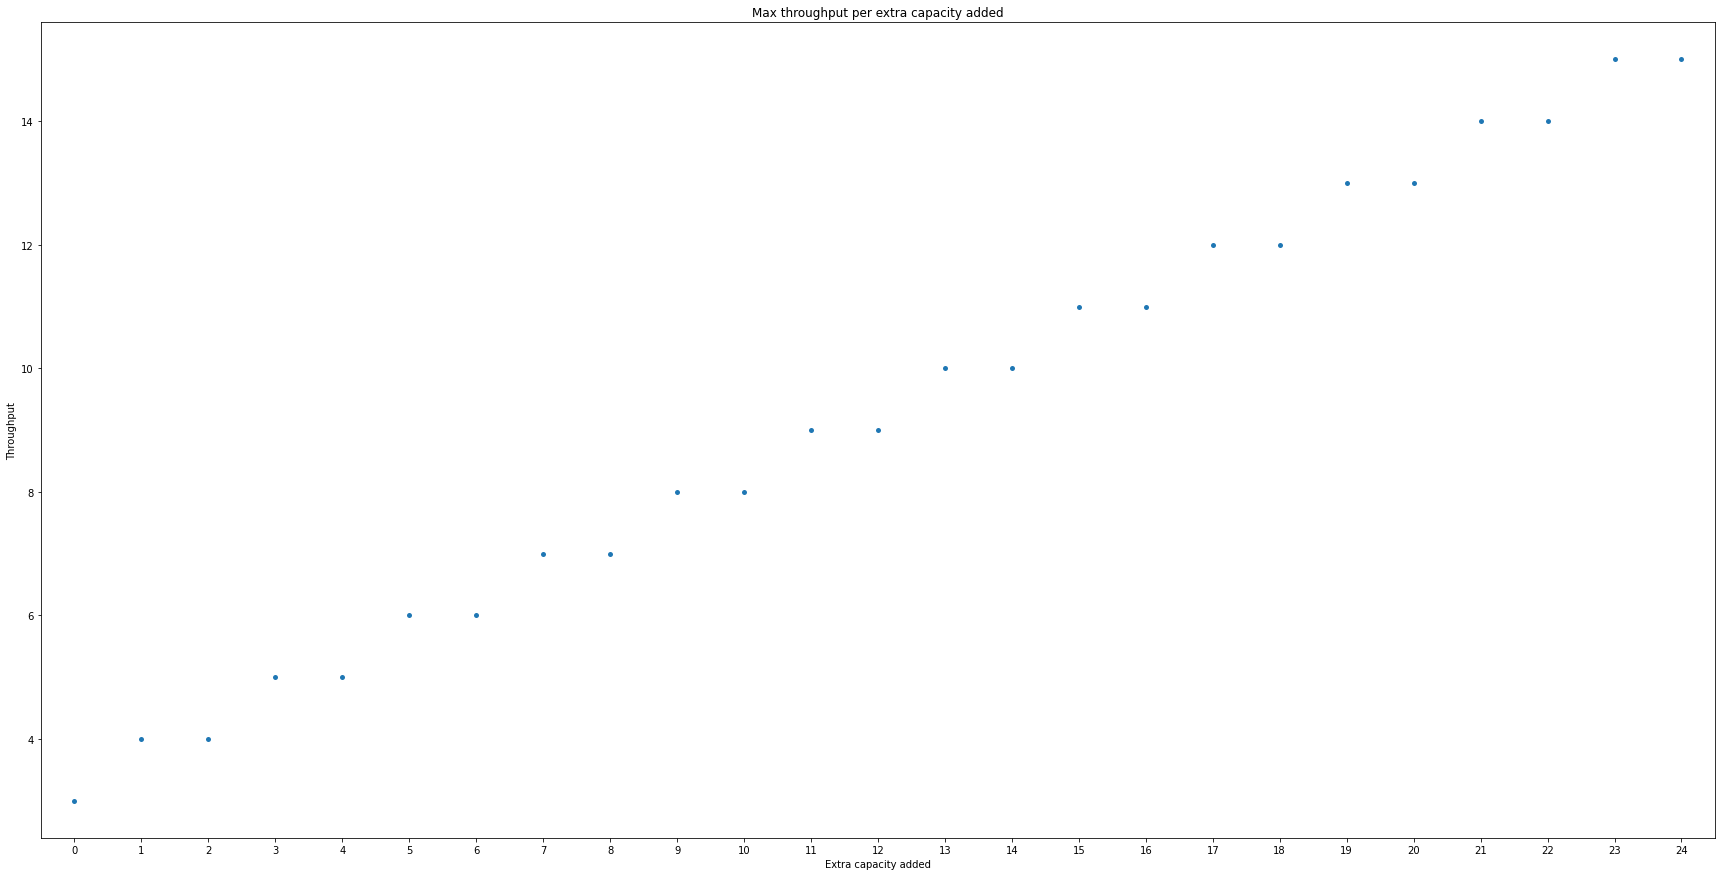

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(1, figsize=(30,15))

n = 25
ax = sns.stripplot(x=list(throughput_per_cap.keys())[:n], y=list(throughput_per_cap.values())[:n]);
  
# giving labels to x-axis and y-axis
ax.set(xlabel ='Extra capacity added', ylabel ='Throughput')
  
# giving title to the plot
plt.title('Max throughput per extra capacity added');
  
# function to show plot
plt.show()